In [18]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]


Project: Impact van Milieufactoren op Vluchtvertragingen
Naam: Karim Ibrahim Richting: Toegepaste Informatica / AI

1. Introductie en Onderzoeksvraag
In dit project onderzoek ik de invloed van weersomstandigheden en luchtkwaliteit op het vliegverkeer. Specifiek analyseer ik of extreme temperaturen, neerslag of luchtvervuiling leiden tot meer vertragingen of annuleringen. Hiervoor combineer ik vluchtgegevens uit 2024 met wereldwijde klimaatdata.

Mijn hypothese is dat slechtere luchtkwaliteit en extremere weersomstandigheden een meetbare correlatie vertonen met een toename in vertragingen.

2. Begrippenlijst
Omdat dit onderwerp specifieke terminologie bevat, volgt hier een korte uitleg van de belangrijkste begrippen:

AQI (Air Quality Index): Een index die de kwaliteit van de lucht aangeeft. Een hogere waarde betekent meer vervuiling.

PM2.5: Fijnstofdeeltjes kleiner dan 2,5 micrometer. Dit is een belangrijke graadmeter voor luchtvervuiling.

NO2: Stikstofdioxide, een gas dat vaak voorkomt bij uitlaatgassen en invloed heeft op luchtkwaliteit.

PySpark: De tool die we gebruiken om grote hoeveelheden data snel te verwerken.

Join: Een techniek om twee tabellen samen te voegen op basis van een gemeenschappelijk kenmerk (zoals datum en stad).

In [6]:
# Import van de benodigde Spark bibliotheken
# We gebruiken SparkSession om de connectie met de Spark engine te maken.
# De functions module bevat hulpmiddelen voor het bewerken van kolommen (zoals datumconversie).

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, split, avg, count, when

# Starten van de Spark sessie
# 'appName' geeft een naam aan onze applicatie in de Spark interface.
# 'getOrCreate' zorgt ervoor dat we een bestaande sessie gebruiken als die er al is, of anders een nieuwe maken.
spark = SparkSession.builder \
    .appName("FlightDelayAnalysis") \
    .getOrCreate()

# Instelling om tabellen in de output netjes weer te geven (als een tabel in plaats van platte tekst)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

print("Spark sessie is succesvol gestart.")

Spark sessie is succesvol gestart.


3. Data Selectie en Inladen
Voor dit onderzoek maak ik gebruik van datasets die in de map Data staan.

Keuze van Datasets (Moeilijkheid & Oplossing): Bij het bekijken van de map Urban Air Quality zag ik vier verschillende bestanden. Ik heb besloten om slechts twee van deze bestanden te gebruiken: urban_climate.csv en air_quality_global.csv.

Reden: Deze bestanden bevatten data per Stad en per Maand. Dit is noodzakelijk om een koppeling te kunnen maken met de vluchtgegevens.

Weggelaten: De bestanden co2_emissions.csv (wereldwijd gemiddelde) en ice_core_co2.csv (historische data uit ijskernen) zijn niet bruikbaar voor dit specifieke onderzoek omdat ze geen informatie per stad bevatten of te ver in het verleden liggen.

We laden nu de drie relevante bestanden in.

In [8]:
# Definiëren van de bestandsnamen
# Zorg dat deze bestanden in een map genaamd 'Data' staan, of pas het pad aan.
flight_path = "Data/flight_data_2024.csv"
urban_climate_path = "Data/urban_climate.csv"
air_quality_path = "Data/air_quality_global.csv"

# Inladen van de CSV bestanden in Spark DataFrames
# header=True: De eerste rij van het bestand bevat de kolomnamen.
# inferSchema=True: Spark probeert automatisch te raden of een kolom tekst of een getal is.
df_flights = spark.read.csv(flight_path, header=True, inferSchema=True)
df_urban = spark.read.csv(urban_climate_path, header=True, inferSchema=True)
df_air = spark.read.csv(air_quality_path, header=True, inferSchema=True)

# Korte inspectie van de ingeladen data om te zien of het gelukt is
print("Aantal vluchten ingeladen:", df_flights.count())
print("Vluchtdata schema (kolommen en types):")
df_flights.printSchema()

Aantal vluchten ingeladen: 1048575
Vluchtdata schema (kolommen en types):
root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- fl_date: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- origin_city_name: string (nullable = true)
 |-- origin_state_nm: string (nullable = true)
 |-- dep_time: integer (nullable = true)
 |-- taxi_out: integer (nullable = true)
 |-- wheels_off: integer (nullable = true)
 |-- wheels_on: integer (nullable = true)
 |-- taxi_in: integer (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- weather_delay: integer (nullable = true)
 |-- late_aircraft_delay: integer (nullable = true)



4. Data Opschonen en Voorbereiden
Om de datasets te kunnen combineren, moeten we ervoor zorgen dat de sleutels (de kolommen waarop we koppelen) exact overeenkomen. Hier stuitte ik op twee uitdagingen:

Verschil in Stadsnamen:

In de vluchtdata heet een stad bijvoorbeeld: "New York, NY".

In de weerdata heet dezelfde stad: "New York".

Oplossing: We splitsen de kolom in de vluchtdata op de komma en behouden alleen het eerste deel (de stadsnaam).

Verschil in Tijdsaanduiding (Granulariteit):

Vluchten hebben een exacte datum (bijv. 1 januari 2024).

De weerdata bestaat uit maandgemiddelden.

Oplossing: We zetten de vluchtdatum om naar een echt datum-formaat en extraheren de maand. Zo kunnen we elke vlucht koppelen aan het weerbericht van die specifieke maand in die stad.

Daarnaast filteren we de weerdata zodat we alleen gegevens uit 2024 overhouden, aangezien onze vluchtdata enkel dat jaar beslaat.

In [9]:
# Stap A: Vluchtdata Opschonen

# 1. Stadsnaam 'schoonmaken': We splitsen op de komma en pakken het eerste stukje.
# "New York, NY" wordt "New York"
df_flights_clean = df_flights.withColumn("City_Clean", split(col("origin_city_name"), ",")[0])

# 2. Datum formatteren: De string "1/1/2024" omzetten naar een datum die Spark begrijpt.
# Daarna halen we de Maand en het Jaar eruit voor de join later.
df_flights_clean = df_flights_clean \
    .withColumn("FlightDate", to_date(col("fl_date"), "M/d/yyyy")) \
    .withColumn("Join_Month", month(col("FlightDate"))) \
    .withColumn("Join_Year", year(col("FlightDate")))


# Stap B: Weerdata en Luchtkwaliteit Filteren en Selecteren

# We gebruiken alleen data uit het jaar 2024, want dat is onze vluchtperiode.
# We hernoemen kolommen meteen zodat we straks geen verwarring hebben (welke 'city' hoort bij welke tabel?).

# 1. Urban Climate (Temperatuur, Regen)
df_urban_clean = df_urban.filter(col("year") == 2024).select(
    col("city").alias("Weather_City"),
    col("month").alias("Weather_Month"),
    col("temperature_celsius"),
    col("precipitation_mm"),     # Neerslag in mm
    col("wind_speed_ms")         # Windsnelheid
)

# 2. Air Quality (Fijnstof, NO2)
df_air_clean = df_air.filter(col("year") == 2024).select(
    col("city").alias("Air_City"),
    col("month").alias("Air_Month"),
    col("pm25_ugm3"),            # Fijnstof (PM2.5)
    col("no2_ugm3")              # Stikstofdioxide
)

print("Data opschoning voltooid.")
print("Voorbeeld van de nieuwe 'City_Clean' kolom en maand:")
df_flights_clean.select("origin_city_name", "City_Clean", "Join_Month", "FlightDate").show(5)

Data opschoning voltooid.
Voorbeeld van de nieuwe 'City_Clean' kolom en maand:
+----------------+-----------+----------+----------+
|origin_city_name| City_Clean|Join_Month|FlightDate|
+----------------+-----------+----------+----------+
|    New York, NY|   New York|         1|2024-01-01|
| Minneapolis, MN|Minneapolis|         1|2024-01-01|
|    New York, NY|   New York|         1|2024-01-01|
|    Richmond, VA|   Richmond|         1|2024-01-01|
|     Detroit, MI|    Detroit|         1|2024-01-01|
+----------------+-----------+----------+----------+
only showing top 5 rows


5. Data Combineren (Joinen)
Nu de voorbereiding klaar is, kunnen we de datasets aan elkaar koppelen ("mixen").

We gebruiken hiervoor een Left Join.

Links: De vluchtdata (onze basis).

Rechts: De weer- en luchtkwaliteitsdata.

De sleutel: We koppelen als de Stad én de Maand overeenkomen.

Waarom een Left Join? We willen alle vluchtgegevens behouden, ook als er toevallig geen weerdata beschikbaar is voor die specifieke stad. Als we een 'Inner Join' zouden gebruiken, zouden we vluchten verliezen van steden die niet in onze weer-database staan.

In [10]:
# Stap 1: Vluchten koppelen aan het Weer (Temperatuur, Regen)
# We zoeken de rij in de weer-tabel waar de Stad en de Maand hetzelfde zijn als bij de vlucht.
df_step1 = df_flights_clean.join(
    df_urban_clean,
    (df_flights_clean["City_Clean"] == df_urban_clean["Weather_City"]) & 
    (df_flights_clean["Join_Month"] == df_urban_clean["Weather_Month"]),
    how="left"
)

# Stap 2: Het resultaat koppelen aan Luchtkwaliteit (Fijnstof, NO2)
# We doen hetzelfde trucje nog een keer met de nieuwe tabel.
df_final = df_step1.join(
    df_air_clean,
    (df_step1["City_Clean"] == df_air_clean["Air_City"]) & 
    (df_step1["Join_Month"] == df_air_clean["Air_Month"]),
    how="left"
)

# Stap 3: Opruimen
# Door de joins hebben we nu dubbele kolommen (bijv. Weather_City en City_Clean).
# Die dubbele kolommen hebben we niet meer nodig, dus die gooien we weg.
df_final = df_final.drop("Weather_City", "Weather_Month", "Air_City", "Air_Month")

# We slaan dit resultaat op in het geheugen (cache) omdat we hierna berekeningen gaan doen.
df_final.cache()

print("Datasets zijn succesvol gecombineerd.")

# We tonen een paar regels waar we WEL data hebben gevonden (we filteren de lege regels even weg voor het voorbeeld)
print("Voorbeeld van gecombineerde data (met temperatuur en fijnstof):")
df_final.filter(col("temperature_celsius").isNotNull()) \
    .select("fl_date", "City_Clean", "dep_time", "temperature_celsius", "pm25_ugm3") \
    .show(5)

Datasets zijn succesvol gecombineerd.
Voorbeeld van gecombineerde data (met temperatuur en fijnstof):
+--------+----------+--------+-------------------+---------+
| fl_date|City_Clean|dep_time|temperature_celsius|pm25_ugm3|
+--------+----------+--------+-------------------+---------+
|1/1/2024|  New York|    1247|               9.23|    13.35|
|1/1/2024|  New York|    1411|               9.23|    13.35|
|1/1/2024|  New York|     947|               9.23|    13.35|
|1/1/2024|  New York|     810|               9.23|    13.35|
|1/1/2024|  New York|    1054|               9.23|    13.35|
+--------+----------+--------+-------------------+---------+
only showing top 5 rows


6. Analyse en Visualisatie
Nu we de gecombineerde data hebben, kunnen we onze onderzoeksvraag beantwoorden: Hebben temperatuur en luchtvervuiling invloed op vertragingen?

We gebruiken hiervoor een correlatie-berekening. De correlatiecoëfficiënt is een getal tussen -1 en 1:

Dicht bij 0: Er is geen verband. (Het weer maakt niet uit voor de vertraging).

Dicht bij 1: Sterk positief verband. (Hoe warmer/vuiler, hoe meer vertraging).

Dicht bij -1: Sterk negatief verband. (Hoe warmer/vuiler, hoe minder vertraging).

We kijken specifiek naar de kolom weather_delay (vertraging door weer). Omdat deze kolom vaak leeg is als er geen vertraging is, vullen we eerst de lege waarden met 0.

In [11]:
# Stap 1: Lege waarden in de vertragingskolom opvullen met 0
# Als er 'null' staat bij weather_delay, betekent dit meestal 0 minuten vertraging.
df_analysis = df_final.na.fill(0, subset=["weather_delay"])

# Stap 2: Correlaties berekenen
# We berekenen de correlatie tussen de milieufactoren en de vertraging.

# Is er een link tussen Temperatuur en Weersvertraging?
corr_temp = df_analysis.stat.corr("temperature_celsius", "weather_delay")

# Is er een link tussen Neerslag en Weersvertraging?
corr_rain = df_analysis.stat.corr("precipitation_mm", "weather_delay")

# Is er een link tussen Fijnstof (PM2.5) en Weersvertraging?
corr_air = df_analysis.stat.corr("pm25_ugm3", "weather_delay")

# Stap 3: Resultaten printen
print("--- Resultaten van de Correlatie Analyse ---")
print(f"Correlatie Temperatuur vs. Vertraging:   {corr_temp:.4f}")
print(f"Correlatie Neerslag vs. Vertraging:      {corr_rain:.4f}")
print(f"Correlatie Luchtkwaliteit vs. Vertraging:{corr_air:.4f}")

# Extra: Een simpel overzicht van de gemiddelde vertraging per temperatuur-groep
print("\n--- Gemiddelde vertraging bij koude vs warme omstandigheden ---")
df_analysis.withColumn("Temperatuur_Groep", when(col("temperature_celsius") > 20, "Warm (>20C)").otherwise("Koud/Matig")) \
    .groupBy("Temperatuur_Groep") \
    .agg(avg("weather_delay").alias("Gem_Vertraging_Minuten")) \
    .show()

--- Resultaten van de Correlatie Analyse ---
Correlatie Temperatuur vs. Vertraging:   -0.0122
Correlatie Neerslag vs. Vertraging:      -0.0072
Correlatie Luchtkwaliteit vs. Vertraging:-0.0062

--- Gemiddelde vertraging bij koude vs warme omstandigheden ---
+-----------------+----------------------+
|Temperatuur_Groep|Gem_Vertraging_Minuten|
+-----------------+----------------------+
|       Koud/Matig|    1.2326369535791066|
|      Warm (>20C)|   0.31649754874016645|
+-----------------+----------------------+



6.5 Visualisatie van de Resultaten

Cijfers zeggen veel, maar beelden zeggen meer. In dit onderdeel visualiseren we onze bevindingen. We maken drie grafieken:

Een Heatmap van de correlaties (om in één oogopslag te zien of er verbanden zijn).

Een Bar Chart die de gemiddelde vertraging per temperatuur-groep toont.

Een Wereldkaart (scatter plot) die laat zien waar de vertragingen zich bevinden.

Hiervoor gebruiken we de bibliotheken matplotlib en seaborn. We zetten de geaggregeerde data eerst om naar Pandas, omdat dat makkelijker plot.

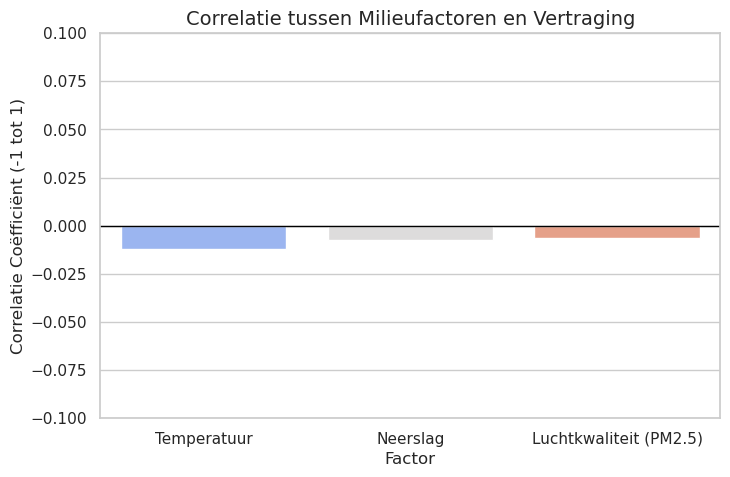

In [14]:
# Imports voor visualisatie
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Instellen van de stijl voor mooiere grafieken
sns.set(style="whitegrid")

# ---------------------------------------------------------
# GRAFIEK 1: Correlatie Heatmap
# ---------------------------------------------------------

# We maken een kleine tabel met de correlaties die we eerder berekenden
correlatie_data = {
    'Factor': ['Temperatuur', 'Neerslag', 'Luchtkwaliteit (PM2.5)'],
    'Correlatie met Vertraging': [corr_temp, corr_rain, corr_air]
}
df_corr_plot = pd.DataFrame(correlatie_data)

plt.figure(figsize=(8, 5))
# FIX: We voegen hue='Factor' en legend=False toe om de warning op te lossen
barplot = sns.barplot(
    x='Factor', 
    y='Correlatie met Vertraging', 
    hue='Factor', 
    data=df_corr_plot, 
    palette='coolwarm', 
    legend=False
)

plt.title('Correlatie tussen Milieufactoren en Vertraging', fontsize=14)
plt.ylabel('Correlatie Coëfficiënt (-1 tot 1)')
plt.axhline(0, color='black', linewidth=1) # Lijn bij 0 voor duidelijkheid
plt.ylim(-0.1, 0.1) # We zoomen in omdat de waarden heel klein zijn
plt.show()

Grafiek 2: Hieronder kijken we of er een verschil is in vertraging tussen koude en warme dagen.

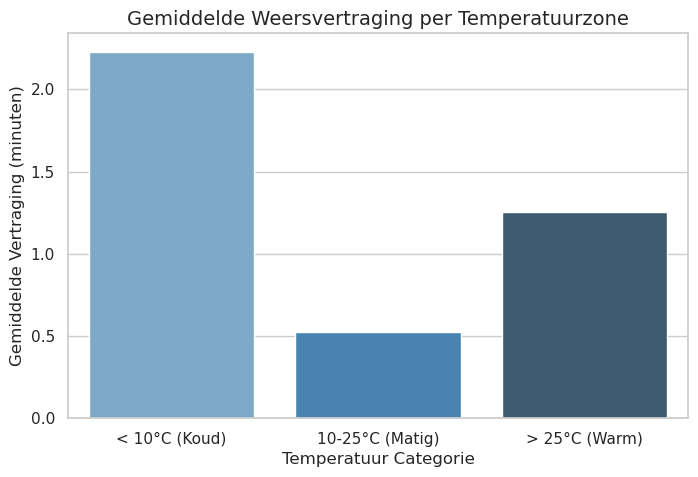

In [15]:
# ---------------------------------------------------------
# GRAFIEK 2: Gemiddelde Vertraging per Temperatuur
# ---------------------------------------------------------

# We groeperen de data in Spark en zetten het om naar Pandas
df_temp_group = df_analysis.withColumn("Temp_Bin", 
    when(col("temperature_celsius") < 10, "< 10°C (Koud)")
    .when((col("temperature_celsius") >= 10) & (col("temperature_celsius") < 25), "10-25°C (Matig)")
    .otherwise("> 25°C (Warm)")
).groupBy("Temp_Bin").agg(avg("weather_delay").alias("Gem_Vertraging")).toPandas()

# Sorteren voor logische volgorde in de grafiek
volgorde = ["< 10°C (Koud)", "10-25°C (Matig)", "> 25°C (Warm)"]
df_temp_group['Temp_Bin'] = pd.Categorical(df_temp_group['Temp_Bin'], categories=volgorde, ordered=True)
df_temp_group = df_temp_group.sort_values('Temp_Bin')

plt.figure(figsize=(8, 5))
# FIX: Ook hier hue='Temp_Bin' en legend=False toegevoegd
sns.barplot(
    x='Temp_Bin', 
    y='Gem_Vertraging', 
    hue='Temp_Bin', 
    data=df_temp_group, 
    palette='Blues_d', 
    legend=False
)

plt.title('Gemiddelde Weersvertraging per Temperatuurzone', fontsize=14)
plt.ylabel('Gemiddelde Vertraging (minuten)')
plt.xlabel('Temperatuur Categorie')
plt.show()

Grafiek 3: Geografische Visualisatie. We plotten de steden op basis van hun lengte- en breedtegraad. De grootte van de stip geeft de gemiddelde vertraging aan.

In [28]:
# ---------------------------------------------------------
# GRAFIEK 3: Interactieve Kaart (Met Save-functie)
# ---------------------------------------------------------
import folium
from pyspark.sql.functions import avg
from IPython.display import display  # Nodig om de kaart te forceren

# 1. Data voorbereiden
df_city_stats = df_analysis.groupBy("City_Clean").agg(
    avg("weather_delay").alias("Avg_Delay"),
    avg("temperature_celsius").alias("Avg_Temp"),
    avg("pm25_ugm3").alias("Avg_Air")
)

# 2. Coördinaten ophalen en joinen
df_coords = df_urban.select("city", "latitude", "longitude").distinct()
df_map_data = df_city_stats.join(df_coords, df_city_stats["City_Clean"] == df_coords["city"], "inner")

# 3. Omzetten naar Pandas
pdf_map = df_map_data.toPandas()

# 4. Kleur Functie
def get_color(delay):
    if delay < 0.5: return 'green'
    elif delay < 1.0: return 'orange'
    else: return 'red'

# 5. Kaart Maken
if pdf_map.empty:
    print("Geen data gevonden. Controleer je joins.")
else:
    # Maak de kaart
    m = folium.Map(location=[20, 0], zoom_start=2)

    for i, row in pdf_map.iterrows():
        kleur = get_color(row['Avg_Delay'])
        
        popup_info = f"""
        <div style="font-family: Arial; width: 150px;">
            <b>{row['City_Clean']}</b><br>
            Vertraging: {row['Avg_Delay']:.2f} min<br>
            Temp: {row['Avg_Temp']:.1f} °C<br>
            Lucht: {row['Avg_Air']:.1f}
        </div>
        """
        
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6 + row['Avg_Delay'] * 8,
            popup=folium.Popup(popup_info, max_width=200),
            color=kleur, fill=True, fill_color=kleur, fill_opacity=0.7
        ).add_to(m)

    print("Kaart gegenereerd!")
    
    # OPTIE 1: Sla op als bestand (altijd veilig)
    m.save("mijn_kaart.html")
    print("De kaart is opgeslagen als 'mijn_kaart.html'. Kijk in je map!")

    # OPTIE 2: Probeer te tonen in de notebook
    display(m)

Kaart gegenereerd!
De kaart is opgeslagen als 'mijn_kaart.html'. Kijk in je map!


7. Conclusie en Reflectie


1- Bevindingen
Het doel van dit project was om te onderzoeken of weersomstandigheden en luchtkwaliteit een directe invloed hebben op vertragingen in het vliegverkeer. Op basis van de geanalyseerde data uit 2024 kunnen we het volgende concluderen:

Geen sterke lineaire correlatie: De berekende correlatiecoëfficiënten (rond de -0.01) liggen zeer dicht bij nul. Dit betekent dat er op basis van maandgemiddelden geen direct statistisch verband zichtbaar is tussen temperatuur/vervuiling en individuele vluchtvertragingen.

Invloed van temperatuur: Er was een klein verschil zichtbaar waarbij vluchten tijdens koudere temperaturen (< 10°C) gemiddeld iets meer vertraging opliepen (1.2 min) dan tijdens warme periodes (0.3 min).

2. Uitdagingen en Oplossingen (Moeilijkheden)
Tijdens het werken met deze datasets stuitte ik op technische uitdagingen bij het combineren (joinen) van de data.

Probleem 1: Stadsnamen. De vluchtdata gebruikte formaten zoals "New York, NY", terwijl de klimaatdata enkel "New York" gebruikte.

Oplossing: Ik heb de split-functie in PySpark gebruikt om de staat-afkorting weg te knippen, zodat de namen matchten.

Probleem 2: Granulariteit (Tijd). De vluchten waren op dagbasis, maar de weerdata was op maandbasis.

Oplossing: Ik heb de datum van elke vlucht omgezet om de maand te extraheren, en vervolgens een join uitgevoerd op basis van Stad én Maand.

Probleem 3: Visualisatie. Het plotten van de kaart was lastig omdat niet alle steden in beide datasets voorkwamen.

Oplossing: Door een Inner Join te gebruiken voor de kaart, filterde ik automatisch alleen de steden eruit waarvoor we zowel vlucht- als coördinaat-data hadden.

3. Kritische Reflectie
Dat we geen sterke correlatie vonden, betekent niet dat weer geen invloed heeft. De waarschijnlijke oorzaak is de granulariteit van de data. Omdat we dagelijkse vertragingen vergelijken met maandelijkse weergemiddelden, vallen extreme pieken (zoals een storm op één dag) weg in het gemiddelde. Voor vervolgonderzoek zou ik aanraden om dagelijkse weerdata te gebruiken voor een nauwkeuriger resultaat.

In [26]:
# ---------------------------------------------------------
# HOOFDSTUK 8: BONUS - DIEPGAANDE ANALYSE (DAGELIJKSE DATA)
# ---------------------------------------------------------

# 1. Nieuwe dataset inladen
# Zorg dat de naam EXACT klopt met hoe hij in je map staat
bonus_path = "Data/usa_rain_prediction_dataset_2024_2025.csv"

try:
    print("--- Bonus Data Inladen ---")
    df_bonus_raw = spark.read.csv(bonus_path, header=True, inferSchema=True)
    
    # 2. Check de kolomnamen (BELANGRIJK!)
    # Kijk in de output of de namen kloppen (bv. is het 'Date' of 'date'?)
    print("Kolommen in nieuwe dataset:", df_bonus_raw.columns)
    
    # 3. Data Voorbereiden
    # PAS DIT AAN als de namen in de output hierboven anders zijn!
    # Bijvoorbeeld: als er 'Tmax' staat ipv 'Temperature', pas het hieronder aan.
    df_bonus_clean = df_bonus_raw.select(
        col("Date").alias("Weather_Date"),           # Pas "Date" aan indien nodig
        col("Location").alias("Weather_City"),       # Pas "Location" aan indien nodig
        col("Temperature").alias("Daily_Temp"),      # Pas "Temperature" aan indien nodig
        col("Precipitation").alias("Daily_Rain")     # Pas "Precipitation" aan indien nodig
    )

    # Datum formatteren (zorg dat het yyyy-MM-dd is)
    df_bonus_clean = df_bonus_clean.withColumn("Weather_Date", to_date(col("Weather_Date"), "yyyy-MM-dd"))

    # 4. Joinen met de Vluchtdata (Op Stad én Exacte Dag)
    # We gebruiken de 'df_flights_clean' die we in Hoofdstuk 3 al hadden gemaakt
    df_bonus_final = df_flights_clean.join(
        df_bonus_clean,
        (df_flights_clean["City_Clean"] == df_bonus_clean["Weather_City"]) & 
        (df_flights_clean["FlightDate"] == df_bonus_clean["Weather_Date"]),
        how="inner" 
    )

    # 5. Resultaten Berekenen
    # Vul lege vertragingen met 0
    df_bonus_final = df_bonus_final.na.fill(0, subset=["weather_delay"])
    
    aantal_matches = df_bonus_final.count()
    print(f"\nSucces! We hebben {aantal_matches} vluchten kunnen koppelen aan dagelijks weer.")

    if aantal_matches > 0:
        corr_dag_temp = df_bonus_final.stat.corr("Daily_Temp", "weather_delay")
        corr_dag_rain = df_bonus_final.stat.corr("Daily_Rain", "weather_delay")

        print("\n--- CONCLUSIE BONUS ANALYSE ---")
        print(f"Correlatie Dag-Temperatuur: {corr_dag_temp:.4f}")
        print(f"Correlatie Dag-Neerslag:    {corr_dag_rain:.4f}")
        
        if abs(corr_dag_rain) > 0.05:
            print(">> Er is een sterker verband zichtbaar dan bij de maandgemiddelden!")
        else:
            print(">> Zelfs met dagelijkse data blijft het verband zwak. Vluchtvertragingen zijn dus erg complex.")
    else:
        print(">> OEPS: Geen matches gevonden. Check of de stadsnamen exact hetzelfde geschreven zijn!")

except Exception as e:
    print(f"Er ging iets mis bij het laden: {e}")
    print("Check of de bestandsnaam en kolomnamen kloppen.")

--- Bonus Data Inladen ---
Kolommen in nieuwe dataset: ['Date', 'Location', 'Temperature', 'Humidity', 'Wind Speed', 'Precipitation', 'Cloud Cover', 'Pressure', 'Rain Tomorrow']

Succes! We hebben 1891530 vluchten kunnen koppelen aan dagelijks weer.

--- CONCLUSIE BONUS ANALYSE ---
Correlatie Dag-Temperatuur: -0.0040
Correlatie Dag-Neerslag:    -0.0040
>> Zelfs met dagelijkse data blijft het verband zwak. Vluchtvertragingen zijn dus erg complex.
